<h1> use the other one in this folder </h1>
<h1> Python Analysis with "Big Data" </h1>
<h1> By Mark Zusman </h1>
<br>
<br>
This notebook was created using a Jupyer Lab ide on the Ohio Super Computer (OSC).  The session was a Jupyter and Spark session.  This allows for the notebook to initally come with preset Spark and SparkContext variables.  
<br>
<i>*Note if an OSC Jupyter and Spark session is not run you will need to install Spark and create a SparkContext variable to get the full utility of this notebook* </i>



<h2> Part 1 : Overview </h2>
<br>
Why is understanding the concept of big data analysis so important?  In today's age, companies are collecting massive amounts of data.  This data can accumulate rather quickly and many times using your typical analyzation techniques may not be the best approach to trying to digest this data.  The process of big data starts as soon even before you select a data set.  There are a lot of overlooked concepts that go into big data analysis.  This book highlights the best practice methods in many areas of analysis such as gathering, cleaning, and displaying your data alongside ensuring proper documentation every step of the way.  Methods in this book cover how to create data science projects will high reproducility in the future, whether it be you or someone else looking at it then.  The goal of this notebook is to display the process and derive results along the way.  
<br>
<br>


<h2> Part: 2 The Data</h2>
In part 2 of the notebook, the first look at the data will be taken.  The data set was chosen because of its practical use in a normal business setting.  The dataset is the churn prediction from customers at a bank.  Churn is a word that indicates when a previous customer has left a company to go to another company.  Analysis of churn rate is useful because it can be used to understand what qualities of a company make people stay or leave.   Each row contains customer information with columns of data including the customers' credit score, geography, gender, age, tenure, balance, number of products in use, use of credit card, active member status, estimated salary, and if they have churned.
<br>
<br>
This first part of the notebook will be responsible for establishing the data pipeline and ensuring the data gathered is of high quality.  The data was downloaded from "Kaggle.com", a website that has many data sets available for download.  The data was downloaded and loaded into this notebook as a .csv file.  After the data was loading the data into the notebook the contents of the data were explored to get an overview of what the dataset looks like. 
<br>
<br>
URL for the dataset ==> (https://www.kaggle.com/code/kmalit/bank-customer-churn-prediction/notebook)

In [1]:
#==============IMPORTS=================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import isnan, when, count, col
from pyspark.mllib.stat import Statistics


In [36]:
#versions used
print("Pandas version: {}".format(pd.__version__))
print("PySpark version: {}".format(pyspark.__version__))
print("Seaborn version: {}".format(sns.__version__))

#Pandas version: 1.1.5
#PySpark version: 3.4.1
#Seaborn version 0.11.2


Pandas version: 1.1.5
PySpark version: 3.4.1
Seaborn version: 0.11.2


In [3]:
#checking to see if the spark context variable is instantiated  
sc


<SparkContext master=spark://p0015.ten.osc.edu:60272 appName=pyspark-shell>

In [4]:
#checking to see if the spark variable is instantiated
spark


In [5]:
#creating a spark session
spark = SparkSession.builder.appName('churn-bank').getOrCreate()
     

In [38]:
#the sqlc variable (SQL context) is not defined we will have to define it
sqlc = SQLContext(sc)


/apps/spark/3.4.1/python/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [39]:
#checking to see if the SQL context variable exists
sqlc


In [9]:
#reading in the CSV as a pandas csv
pandas_df = pd.read_csv("Churn_Modelling_Data.csv") 

#genrating a spark data frame
df= spark.createDataFrame(pandas_df) 

#creating a copy of df
backup_df = df

In [10]:
#printing the schema of the Spark data frame to see the categories. 
df.printSchema()

root
 |-- RowNumber: long (nullable = true)
 |-- CustomerId: long (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: long (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Tenure: long (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: long (nullable = true)
 |-- HasCrCard: long (nullable = true)
 |-- IsActiveMember: long (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: long (nullable = true)



In [12]:
#getting the size of each of the rows in the dataframe
df.describe().show(1)


+-------+---------+----------+-------+-----------+---------+------+-----+------+-------+-------------+---------+--------------+---------------+------+
|summary|RowNumber|CustomerId|Surname|CreditScore|Geography|Gender|  Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+-------+---------+----------+-------+-----------+---------+------+-----+------+-------+-------------+---------+--------------+---------------+------+
|  count|    10000|     10000|  10000|      10000|    10000| 10000|10000| 10000|  10000|        10000|    10000|         10000|          10000| 10000|
+-------+---------+----------+-------+-----------+---------+------+-----+------+-------+-------------+---------+--------------+---------------+------+
only showing top 1 row



In [13]:
#checking the null values in the data set.  If there are a lot we will need to determine how to go about dealing with them.  
df.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in df.columns]).show() 

+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|        0|         0|      0|          0|        0|     0|  0|     0|      0|            0|        0|             0|              0|     0|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+



In [11]:
#checking the data in the columns
df.show(5)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|

<h2> Part 3: Analyzing the Data</h2>
<h4> Part A: visualizing column distributions</h4>
After getting the data into the notebook further analyzation of the data can be performed.  The goal of this notebook is to derive useful information for the bank.  Getting an understanding of what type of customers are at the bank, how many of the bank's customers are churning, and what could be the cause of customers leaving the bank would help the bank from a business point of view.   

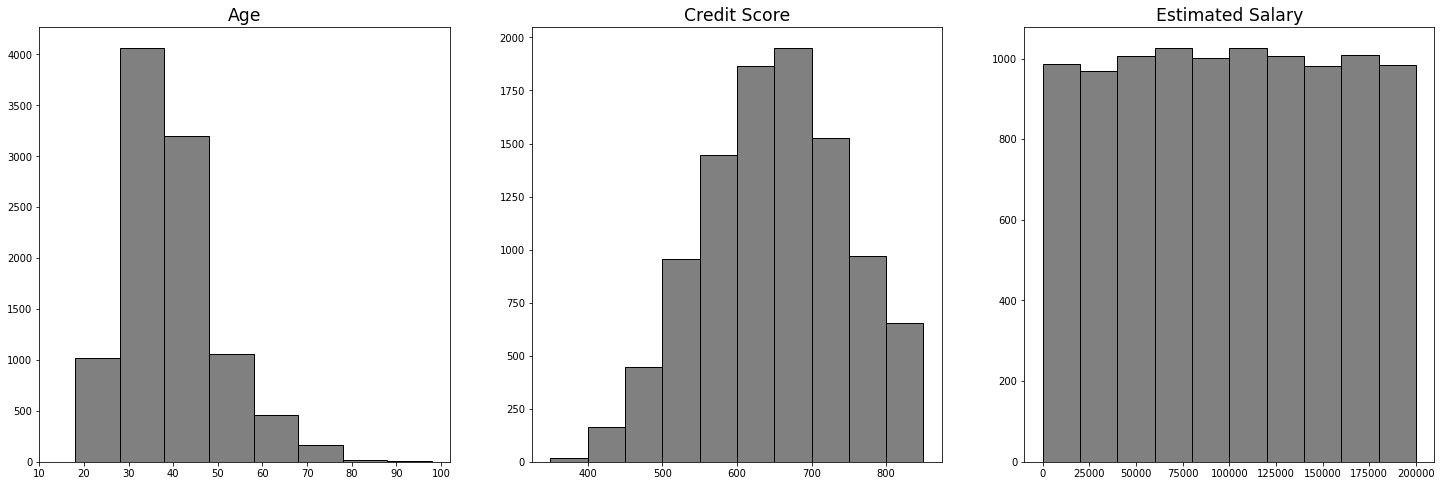

In [40]:
#visualizing age, credit score and salary distributions in the dataset

plt.figure(figsize = (25,8))

#age plot
binwidth = 10
plt.subplot(131)
plt.hist(pandas_df["Age"], color = 'grey', edgecolor = 'black', bins=range(min(pandas_df["Age"]), max(pandas_df["Age"]) + binwidth, binwidth))
plt.xticks([10,20,30,40,50,60,70,80,90,100])
plt.title("Age", size = "xx-large")

#credit score plot
plt.subplot(132)
plt.hist(pandas_df["CreditScore"], color = 'grey', edgecolor = 'black')
plt.title("Credit Score", size = "xx-large")

#estimated salary plot
plt.subplot(133)
plt.hist(pandas_df["EstimatedSalary"], color = 'grey', edgecolor = 'black') 
plt.title("Estimated Salary", size = "xx-large")


plt.show()

All three of these graphs have a different distribution.   There is a skew to the left side of the graph for the ages of the bank customers.  The credit score graph seems to have a normal bell-shaped curve distribution with the largest bins in the histogram toward the middle of the graph.  Lastly, there seems to be an even distribution of the bank customers' estimated salary.   

<h4> Part B: Showing Churn percent and count</h4>

In [15]:
#to make the values in the Exited col to "yes" and "no" instead of 0s and 1s
#first we need to see all the values in the col currently
df.select("Exited").distinct().show() 
# 0 ==> No
# 1 ==> Yes

+------+
|Exited|
+------+
|     0|
|     1|
+------+



In [16]:
#updating the "Exited" col.  O is mapped to "No".  1 is mapped to "Yes".  All other values will become "Unknown"
updated_df = df.withColumn("Exited", when(df["Exited"] == 0,"No") 
.when(df["Exited"] == 1,"Yes") 
.otherwise("Unknown")) 

In [17]:
#checking the data was correctly updated
updated_df.show(5)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|   Yes|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|    No|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|   Yes|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|

In [18]:
#converting the Spark data frame to pandas to graph
pandas_df = updated_df.toPandas()

In [19]:
#setting up two lists to create graphs displaying the churn percentage and number of bank members churning.  

no_list = 0
yes_list = 0

for i in range(len(pandas_df["Exited"])):
    if pandas_df["Exited"][i] == "No":
        no_list = no_list +1
    if pandas_df['Exited'][i] == "Yes":
        yes_list = yes_list +1

pie_data_list = [no_list, yes_list]
        
print("No list length: {}".format(no_list))
print("Yes list length: {}".format(yes_list))

print("Length of both lists: {}".format(no_list+yes_list))

No list length: 7963
Yes list length: 2037
Length of both lists: 10000


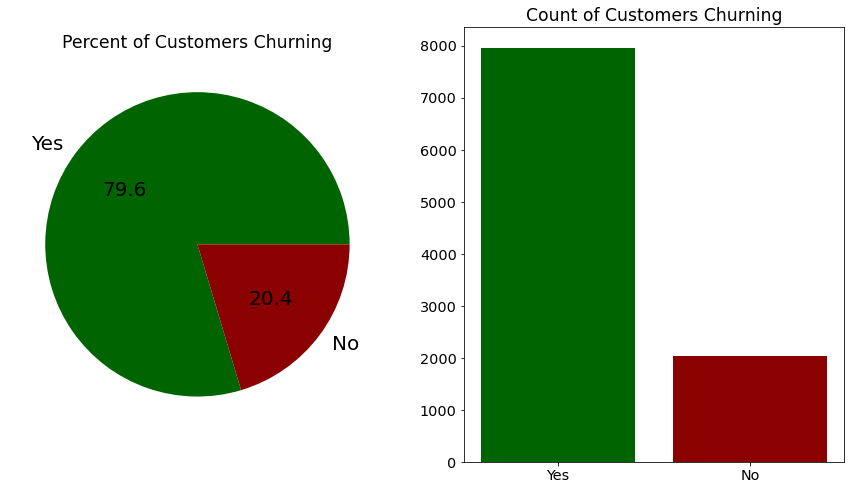

In [20]:
#plotting a pie chart showing the churn breakdown 
labels = ["Yes", "No"]

plt.figure(figsize = (15,8))
plt.subplot(121)
plt.pie(pie_data_list, labels = labels,  autopct='%1.1f', colors=['darkgreen', 'darkred'],  textprops={'fontsize': 20})
plt.title("Percent of Customers Churning", size = "xx-large")
plt.subplot(122)
plt.title("Count of Customers Churning", size = "xx-large")
plt.bar(labels, pie_data_list, color = ["darkgreen", "darkred"])
plt.xticks(size = "x-large")
plt.yticks(size = "x-large")
plt.show()

From these visualizations, it is clear that most customers in the bank stay.  There is a ratio that out of 5 people about 1 person will leave.  

<h4> Part C: Showing Churn Distribution in Specific Columns</h4>
This part combines parts A and B as it makes histograms similar to part A, however, it divides up each bar of the histograms to whether or not a customer churned or not.   

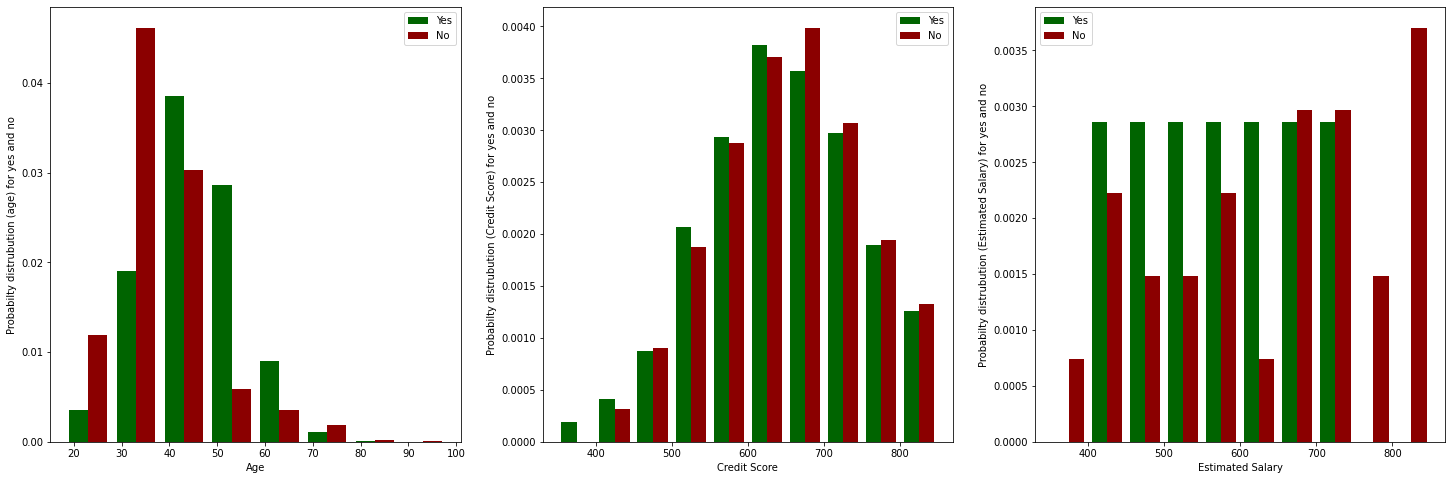

In [21]:
#visualizing the data

colors = ['darkgreen', 'darkred']
names = ['Yes', 'No']

plt.figure(figsize = (25,8))


#Age plot
plt.subplot(131)
x1 =list(pandas_df[pandas_df['Exited'] == "Yes"]["Age"])
x2=list(pandas_df[pandas_df['Exited'] == "No"]["Age"])

binwidth = 10

plt.hist([x1, x2],  density = True, color = colors, label = names, bins=range(min(pandas_df["Age"]), max(pandas_df["Age"]) + binwidth, binwidth))
plt.legend()
plt.xlabel("Age")
plt.ylabel("Probabilty distrubution (age) for yes and no")


#Credit Score plot
plt.subplot(132)
x1 =list(pandas_df[pandas_df['Exited'] == "Yes"]["CreditScore"])
x2=list(pandas_df[pandas_df['Exited'] == "No"]["CreditScore"])

binwidth = 50

plt.hist([x1, x2],  density = True, color = colors, label = names, bins=range(min(pandas_df["CreditScore"]), max(pandas_df["CreditScore"]) + binwidth, binwidth))
plt.legend()
plt.xlabel("Credit Score")
plt.ylabel("Probabilty distrubution (Credit Score) for yes and no")


#Estimated Salary plot
plt.subplot(133)
x1 =list(pandas_df[pandas_df['Exited'] == "Yes"]["EstimatedSalary"])
x2=list(pandas_df[pandas_df['Exited'] == "No"]["EstimatedSalary"])

binwidth = 50

plt.hist([x1, x2],  density = True, color = colors, label = names, bins=range(min(pandas_df["CreditScore"]), max(pandas_df["CreditScore"]) + binwidth, binwidth))
plt.legend()
plt.xlabel("Estimated Salary")
plt.ylabel("Probabilty distrubution (Estimated Salary) for yes and no")



plt.show()


<h4> Part D: Determing Correlation</h4>
To further analyze why customers may leave the bank correlation can be used.  If a company can determine what factors contribute to making a customer leave, then the company can make better business decisions to lower the chance that will happen.  
<br>
<br>
To start the correlation analysis some columns with categorical data will need to be converted to numeric data.  

In [22]:
#getting the categories of data in the "Geography" column
df.select("Geography").distinct().show() 


+---------+
|Geography|
+---------+
|  Germany|
|   France|
|    Spain|
+---------+



In [23]:
#getting the categories of data in the "Gender" column
df.select("Gender").distinct().show() 


+------+
|Gender|
+------+
|Female|
|  Male|
+------+



In [24]:
#loading in df clean each time this cell is run to ensure no data is lost if this cell is run more than one time
df = backup_df

#mapping the Geography col
# Germany ==> 0
# France ==> 1
# Spain ==> 2
# If there are any other cols they will be inputted as unknown
df = df.withColumn("Geography", when(df["Geography"] == "Germany",0) 
.when(df["Geography"] == "France",1) 
.when(df["Geography"] == "Spain",2) 
.otherwise("Unknown"))

#mapping the Gender col
# Male ==> 0
# Female ==> 1
# If there are any other cols they will be inputted as unknown
df = df.withColumn("Gender", when(df["Gender"] == "Male",0) 
.when(df["Gender"] == "Female",1) 
.otherwise("Unknown")) 



In [25]:
#dropping the columns that there is only unique data in the data frame
a = df.drop('RowNumber', "CustomerID", "Surname")

In [26]:
#checking our preprocessing so far to ensure dropped columns are gone and all data is numeric
a.show(2)

+-----------+---------+------+---+------+--------+-------------+---------+--------------+---------------+------+
|CreditScore|Geography|Gender|Age|Tenure| Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+-----------+---------+------+---+------+--------+-------------+---------+--------------+---------------+------+
|        619|        1|     1| 42|     2|     0.0|            1|        1|             1|      101348.88|     1|
|        608|        2|     1| 41|     1|83807.86|            1|        0|             1|      112542.58|     0|
+-----------+---------+------+---+------+--------+-------------+---------+--------------+---------------+------+
only showing top 2 rows



This data frame is now ready for correlation analysis. 

In [27]:
#getting correlation between two variables
temp_corr = df.corr("Age", "Exited")
print("The correlation between Age and Exited is {:.4f}".format(temp_corr))

The correlation between Age and Exited is 0.2853


In [28]:
#building a correlation matrix between all of the values in the processed data frame

features = a.rdd.map(lambda row: row[0:])
correlation_matrix = Statistics.corr(features, method= "pearson")

correlation_df = pd.DataFrame(correlation_matrix)

correlation_df.index, correlation_df.columns = a.columns, a.columns

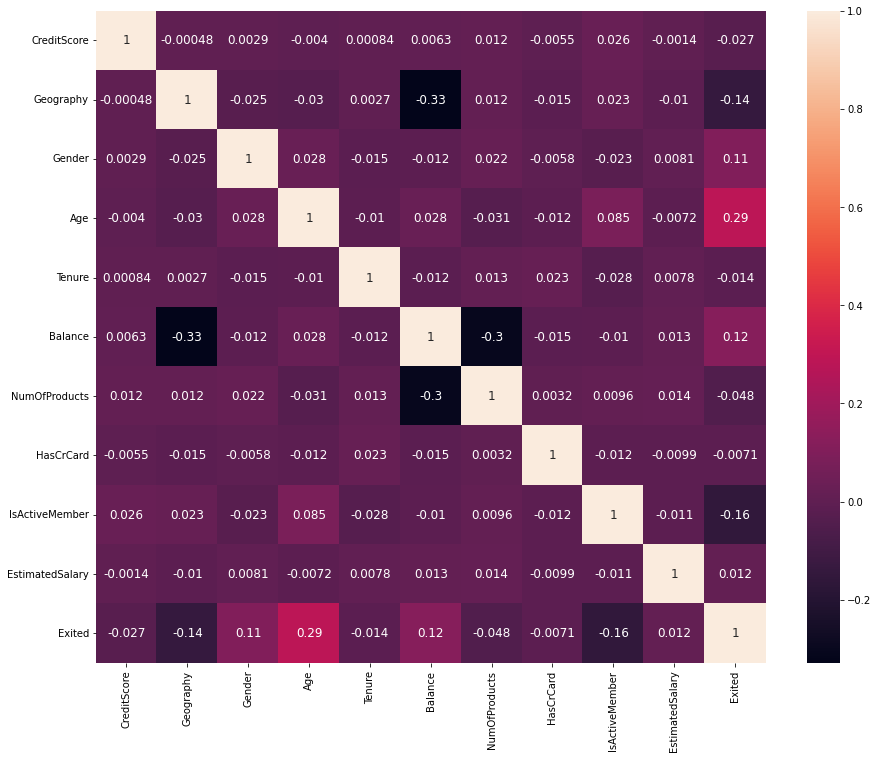

In [29]:
#creating the heat map from the correlation matrix
sns.heatmap(correlation_df, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(15,12)
plt.show()


This heat map displays the correlation between all the numeric column values.  To determine the factors that affect the churn rate at the bank looking at the last column (or row) associated with the "Exited" columns will help.  This column shows how a change in the other columns affects whether or not a customer will leave or not.  From this matrix, it can be determined that age is the largest factor that contributes to the churn rate.  The next two largest factors are determined by whether the customer is an active member and the customer's location.  The second most important factor that determines if a customer will churn if we only consider continuous data is the balance of the customer.

<h4> Part E: Further Analysis Correlation</h4>
In the previous part, we determined what factors contribute the most to determining whether or not a customer will leave or not.  However, we did not consider the way a specific variable changes the "Exited" columns.  In this part, we will take the higher correlated columns of data and determine what about those columns determine if a customer will churn or not.
<br>
<br>
1. The first graph will also be a scatter plot, however, the color of the data points will be the "Exited" column and the axis will be the two continuous columns, Age and Balance.
<br>
2. The next set of graphs will be boxplots that show the distributions of age and balance which compares the customer who churn vs the customers who do not

This graph displays a continuous x variable with a non-continuous y variable.  This type of graph would not be the best at displaying information of this type. 

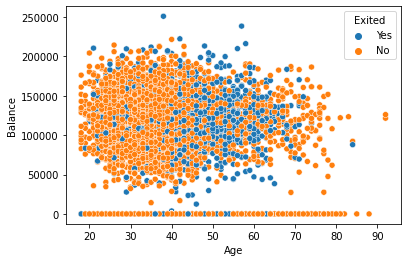

In [33]:
#Using Seaborn to plot a scatter plot of 'Age' vs 'Balance', with 'Exited' as the color of the data points.  
sns.scatterplot(data=pandas_df, x = "Age", y = "Balance", hue = 'Exited')
plt.show()

This graph combines the two graphs and uses color to show the categorical "Exited" variable.  This is better than the "lmplot" graphs from before, however, it is not clear how age and balance determine the "Exited" variable from this v   

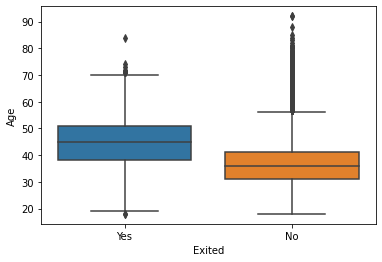

In [34]:
#Creating a box plot comparing the ages of customers who churned vs those who did not
sns.boxplot(x = "Exited", y = "Age", data = pandas_df)
plt.show()

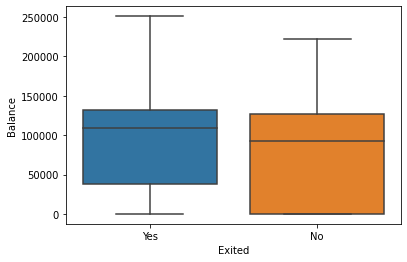

In [35]:
#Creating a box plot comparing the balance of customers who churned vs those who did not
sns.boxplot(x = "Exited", y = "Balance", data = pandas_df)
plt.show()

These box plots are the best visualization method to compare the balance and age of the customers who exitied vs those who did not.  If we compare the means customer who churned have a higher age and balance.  If we look at upper ends of the box plot the higher values of balance and age seem to have more bank customers churning, however, the distributions of the data seem to be close in visual appearance. 

<h2> Part 5: Conclusion</h2>
This notebook highlighted the analysis process that comes when you deal with data.  The main steps of this notebook consisted of starting with a problem, loading in a dataset, understadning the data set, then analyzing the data set.  From the analysis and results it was determined the number and percent of people who left the bank.  After the initial analysis, further analysis was performed to determine the largest factors that contribute to customers leaving the bank.  The two most popular continuous columns of data, age, and balance, were able to be further analyzed.  From this analysis, it was able to be shown that typically a higher age and balance correlate with a higher rate of customer churning.  
<br>
<br>
From this customer churn analysis, the bank will be more aware of what makes customers leave.  They could use what was shown to change their business plan, reatain more customers, and have an overall more successful business.